In [1]:
import pandas as pd
import numpy as np
import MHR as mhr

from sklearn.svm import SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from time import time
%matplotlib inline

def simple_spearman(x,y): return np.abs(spearmanr(x,y)[0])
spearmanr_scorer = make_scorer(simple_spearman)

In [2]:
def reload_package(root_module):
    package_name = root_module.__name__

    # get a reference to each loaded module
    loaded_package_modules = dict([
        (key, value) for key, value in sys.modules.items() 
        if key.startswith(package_name) and isinstance(value, types.ModuleType)])

    # delete references to these loaded modules from sys.modules
    for key in loaded_package_modules:
        del sys.modules[key]

    # load each of the modules again; 
    # make old modules share state with new modules
    for key in loaded_package_modules:
        print 'loading %s' % key
        newmodule = __import__(key)
        oldmodule = loaded_package_modules[key]
        oldmodule.__dict__.clear()
        oldmodule.__dict__.update(newmodule.__dict__)
        
def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def calc_ndcg(df, column,k):
    min_votes=5
    min_comments=30

    ndcg_global=[]
    grouped=df.groupby('asin')

    for name, group in grouped:
        dffiltro = (df['asin']==name)
        
        values_test = df[dffiltro]['helpfulness'].T.to_dict().values()
        scores = df[dffiltro][column].T.to_dict().values()


        ind = (-np.array(scores)).argsort()
        a = np.array(values_test)[ind]	
        ndcg = ndcg_at_k(a, k)
        ndcg_global.append(ndcg)
    return ndcg_global

def calc_ndcg_mean(df, column,k):
    x = calc_ndcg(df,column,k)
    return np.mean(x)

def calc_corr(df, column):
    correlation=[]
    grouped=df.groupby('asin')

    for name, group in grouped:
        dffiltro = (df['asin']==name)
        
        helpfulness = df[dffiltro]['helpfulness'].T.to_dict().values()
        scores = df[dffiltro][column].T.to_dict().values()
        correlation.append(np.corrcoef(helpfulness,scores)[0][1])
    return correlation

In [3]:
reviews_features = pd.read_csv('data/eletronic_sample_counts.csv.gz')
df_agg = reviews_features[['word_count','asin']].groupby(['asin']).agg(['count','mean'])
df_agg['word_count'].sort_values('count',ascending=False).head(10)

,count,mean
asin,,
B00BGA9WK2,351,253.079772
B00A3YN0Z0,219,104.237443
B0074BW614,201,451.900498
B00CMQTVK0,165,334.696970
B0094NY3R0,147,232.972789
B0045FM6SU,140,374.121429
B00DVFLJDS,139,352.625899
B009LL9VDG,133,424.443609
B002C7481G,132,501.636364


In [4]:
#list_asin = ['B00BGA9WK2','B00A3YN0Z0','B0074BW614','B00CMQTVK0','B0094NY3R0','B0045FM6SU','B00DVFLJDS']
#reviews_features = reviews_features[reviews_features.asin.isin(list_asin)]
reviews_features = mhr.executeFromDf(reviews_features)
reviews_features.shape

(19756, 23)

PageRank ndcg=0.87155497918
HITs ndcg=0.871770213457
MHR ndcg=0.8057063917
383
383
383


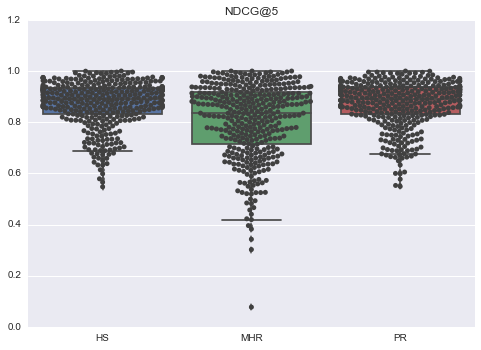

In [7]:
import seaborn as sns
k=5

ndcg_pr=calc_ndcg(reviews_features,'pageRank',k) 
corr_pr=calc_corr(reviews_features,'pageRank') 
print "PageRank ndcg="+str(np.mean(ndcg_pr))

ndcg_hs=calc_ndcg(reviews_features,'hits',k) 
corr_hs=calc_corr(reviews_features,'hits') 
print "HITs ndcg="+str(np.mean(ndcg_hs))

ndcg_mhr=calc_ndcg(reviews_features,'powerWithStar',k) 
corr_mhr=calc_corr(reviews_features,'powerWithStar') 
print "MHR ndcg="+str(np.mean(ndcg_mhr))

print (len(ndcg_hs))
print (len(ndcg_pr))
print (len(ndcg_mhr))

tip={}
tip['HS']=ndcg_hs
tip['PR']=ndcg_pr
tip['MHR']=ndcg_mhr
df = pd.DataFrame(tip)
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, color=".25")
ax.set_title('NDCG@'+str(k))

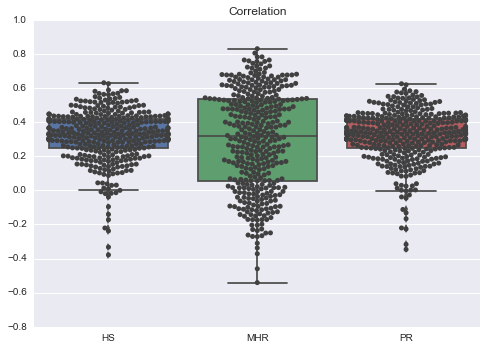

In [9]:
tip={}
tip['PR']=corr_pr
tip['HS']=corr_hs
tip['MHR']=corr_mhr
dftip=pd.DataFrame(tip)
#dftip.head()
ax = sns.boxplot(data=dftip)
ax = sns.swarmplot(data=dftip, color=".25")

ax.set_title('Correlation')